<a href="https://colab.research.google.com/github/KrishnaManeeshaDendukuri/IFT6135_Programming/blob/main/assignment3/q3_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-supervised learning 
In this question, we will implement Simsiam a simple and effective Self-supervised learning (SSL) method. 

If you are running this code on Google Colab, uncomment the below cell and run it. Also, make sure you are saving the models in the right place that they can be used for resuming the training process or as a pretrained model. 

In [1]:
!git clone https://github.com/KrishnaManeeshaDendukuri/IFT6135_Programming.git

Cloning into 'IFT6135_Programming'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 184 (delta 89), reused 71 (delta 24), pack-reused 0
Receiving objects: 100% (184/184), 3.75 MiB | 34.89 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [2]:
#@title Mount your Google Drive
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

# from google.colab import drive
# drive.mount('/content/gdrive')

# install pytorch 1.9
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [3]:
import sys
sys.path.append("/content/IFT6135_Programming/assignment3/")


In [4]:
# import requirements

import math
import os
import random
import shutil


import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np

from q3_solution  import SimSiam

from q3_misc import TwoCropsTransform, load_checkpoints, load_pretrained_checkpoints

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

## Running on GPU
In Google Colab, you can run your code on device. This will be particularly important in CNN part of the assignment. To make sure the notebook is running on device, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`

Be mindful not to use the device if your code does not need to run on GPU.

In [5]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# The parameters we will use

# general
seed = 2022
num_workers = 2
save_path = './'
resume = None #None or a path to a pretrained model (e.g. *.pth.tar')
start_epoch = 0
epochs = 102 #Number of epoches (for this question 100 is enough, however for 1000 epoches, you will get closer results to the original paper)

# data
dir ='./data'
batch_size = 1024

# Siamese backbone model
arch = "resnet18"
fix_pred_lr = True # fix the learning rate of the predictor network

#Simsiam params
dim=2048
pred_dim=512

# ablation experiments
stop_gradient=True # (True or False)
MLP_mode=None # None|'no_pred_mlp'| 'fixed_random_init'

# optimizer
lr = 0.03
momentum = 0.9
weight_decay = 0.0005

# knn params
knn_k = 200 #k in kNN monitor
knn_t = 0.1 #softmax temperature in kNN monitor; could be different with moco-t

In [7]:
# set seeds
random.seed(seed)
torch.manual_seed(seed)
cudnn.deterministic = True

In the next section we will build the Simsiam architecture as shown in this figure (from https://arxiv.org/pdf/2011.10566.pdf). 

# Question 3.1
The network includes an encoder `f` named `self.encoder` and a predictor h named `self.predictor`. 

* Complete the `SimSiam.forward` function  in `q3_solution.py`. This code will receive `x1` and `x2` as:

```
Input:
      x1: first views of images
      x2: second views of images
```
and compute the outputs of the network. which are as below:
```
z1, z2 = f(x1), f(x2) # projections, n-by-d
p1, p2 = h(z1), h(z2) # predictions, n-by-d
```


```
Output:
    p1, p2, z1, z2: predictors and targets of the network
    See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
```



**Note**: Based on the `self.stop_gradient`, this function returns `z1` and `z2` with and without stop gradient. 

**Hint**: In Pytorch, to apply the stop-gradient operation to a variable let say `m`, You can detach it from the graph as `m.detach()`.

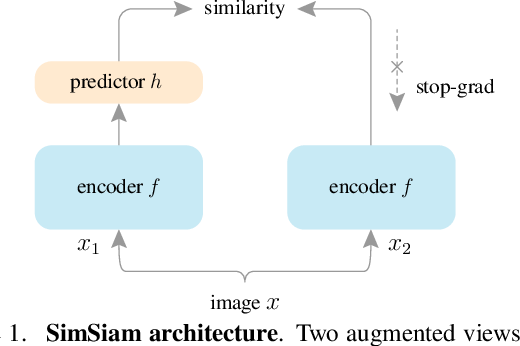

# Question 3.2

* Complete the `CosineSimilarity.forward` function  in `q3_solution.py`. This code compute cosine similarity between two inputs  `x1` and `x2`.

# Question 3.3

* Complete the `SimSiam.loss` function  in `q3_solution.py`. This code compute the Simsiam loss:

```
L = D(p1, z2)/2 + D(p2, z1)/2 
```
where `D` is negative cosine similarity.

Now we can initiate the model. 

In [30]:
# Simsiam Model
print("=> creating model '{}'".format(arch))
model = SimSiam(models.__dict__[arch], dim, pred_dim, stop_gradient=True, MLP_mode=None)
# print(model)

model.to(device)

=> creating model 'resnet18'


SimSiam(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

Now we set the learning rate (LR) of the model. We fix the LR of the predictor as it showed better performance in the original paper. Then we define the optimizer. 

In [31]:
# define and set learning rates
init_lr = lr * batch_size / 256
if fix_pred_lr:
    optim_params = [{'params': model.encoder.parameters(), 'fix_lr': False},
                    {'params': model.predictor.parameters(), 'fix_lr': True}]
else:
    optim_params = model.parameters()

# define optimizer
optimizer = torch.optim.SGD(optim_params, init_lr,
                            momentum=momentum,
                            weight_decay=weight_decay)


In [32]:
# We can resume from a previous checkpoint
if resume:
    model, optimizer, start_epoch = load_checkpoints(os.path.join(resume),model,optimizer,device)

# Dataset and dataloader for Siamese network

In this question, you will work on object classification task of CIFAR10 dataset. We use Pytorch CIFAR10 Dataset to download the dataset so you do not need to download it separately.  This dataset consist of high dimensional images $\mathcal{X} \subset \mathbb{R}^{32\times32\times3}$ of 10 classes. We provide samplers to generate the different distributions that you will need for this question.


In [33]:
# define train and test augmentations for pretraining step 
train_transform = [
    transforms.RandomResizedCrop(32, scale=(0.08, 1.)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])]

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

# datasets and loaders
train_data = datasets.CIFAR10(root=dir, train=True, transform=TwoCropsTransform(transforms.Compose(train_transform)), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)

memory_data = datasets.CIFAR10(root=dir, train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

test_data = datasets.CIFAR10(root=dir, train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In the next cell, we define a train and test function for one epoch of data. We  use k nearest-neighbor (KNN) `knn_predict` to monitor the performance of the model. (see https://arxiv.org/abs/1805.01978 for more details).


In [34]:
# train for one epoch 
def train(train_loader, model, optimizer, device):

    # switch to train mode
    model.train()

    losses = []
    for i, (images, _) in enumerate(train_loader):

        if device is not None:
            images[0] = images[0].to(device, non_blocking=True)
            images[1] = images[1].to(device, non_blocking=True)

        # compute output and loss
        p1, p2, z1, z2 = model(x1=images[0], x2=images[1])
        loss = model.loss(p1,p2,z1,z2,similarity_function='CosineSimilarity')

        losses.append(loss.item())

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses

# save checkpoints 
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

# test using a knn monitor
def test(net, memory_data_loader, test_data_loader, device, knn_k, knn_t ):
    net.eval()
    classes = len(memory_data_loader.dataset.classes)
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for i, (data, target) in enumerate(memory_data_loader):
            feature = net(data.to(device,non_blocking=True))
            feature = F.normalize(feature, dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        for i, (data, target) in enumerate(test_data_loader):
            data, target = data.to(device,non_blocking=True), target.to(device,non_blocking=True)
            feature = net(data)
            feature = F.normalize(feature, dim=1)
            
            pred_labels = knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t)

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()

    return total_top1 / total_num * 100

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
    # weighted score ---> [B, C]
    pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels

# adjust LR
def adjust_learning_rate(optimizer, init_lr, epoch, epochs):
    """Decay the learning rate based on schedule"""
    cur_lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / epochs))
    for param_group in optimizer.param_groups:
        if 'fix_lr' in param_group and param_group['fix_lr']:
            param_group['lr'] = init_lr
        else:
            param_group['lr'] = cur_lr



Now we are ready to pretraining the backbone network. 

# Question 3.4
* train a model for 200 epochs with and without gradient stopping and evaluated them. Plot training loss and Knn accuracy against training epochs. 

**Hint** To run the model without gradient-stopping you need to change `stop_gradient` to `False` and run the notebook. Also, you need to store the training loss and Knn accuracy for each step. 

In [35]:
train_loss = []
test_acc = []

In [36]:
test_acc

[]

In [37]:
# train loop 
for epoch in range(start_epoch, epochs):

    adjust_learning_rate(optimizer, init_lr, epoch, epochs)

    # train for one epoch
    losses = train(train_loader, model, optimizer, device)
    print('Train Epoch: [{}/{}] Train Loss:{:.5f}'.format(epoch, epochs,np.array(losses).mean() ))
    train_loss.append( np.array(losses).mean() )

    # test every 10 epochs
    if epoch % 1 ==0:
        acc1 = test(model.encoder, memory_loader, test_loader, device, knn_k, knn_t)
        print('Test Epoch: [{}/{}] knn_Acc@1: {:.2f}%'.format(epoch, epochs, acc1))
        test_acc.append(acc1)
    
    # save a checkpoint every 20 epochs
    if epoch % 20 == 0:
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': arch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, is_best=False, filename=save_path + '/wo_stopgrad_checkpoint_{:04d}.pth.tar'.format(epoch))


tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.0296e-05, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0017, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0090, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0088, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0089, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0122, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0133, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0127, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0206, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0202, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0204, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0251, device='cud

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()


tensor(0.1844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1843, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.1843, device='cuda:0', grad_fn=<MulBackward0>)


  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


tensor(0.2136, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2157, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.2147, device='cuda:0', grad_fn=<MulBackward0>)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


tensor(0.2086, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2124, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.2105, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2298, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2307, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.2302, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2274, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2334, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.2304, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2617, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2627, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.2622, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2795, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2779, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.2787, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.2809, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2773, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.2791, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

tensor(0.4550, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4519, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4535, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4757, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4701, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4729, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4721, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4728, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4725, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4878, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4829, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4854, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4767, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4782, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4775, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.4779, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4697, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4738, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.5142, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5157, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5149, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5315, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5302, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5308, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5322, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5298, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5310, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5241, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5230, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5235, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5398, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5245, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5322, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5085, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5041, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5063, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.5510, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5497, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5504, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5563, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5542, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5552, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5597, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5460, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5528, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5506, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5679, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5593, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5557, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5547, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5595, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5695, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5645, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


tensor(0.5648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5645, device='cuda:0', grad_fn=<MulBackward0>)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


tensor(0.5566, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5606, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5586, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5620, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5610, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5711, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5631, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5671, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5620, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5624, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5622, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5698, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5645, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5671, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5376, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5392, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5384, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.5798, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5695, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5746, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5548, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5541, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5841, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5803, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5607, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5554, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5660, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5573, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5617, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5696, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5671, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5683, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.5520, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5556, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5538, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5623, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5712, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5667, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5627, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5607, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5617, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5830, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5823, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5826, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5823, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5834, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5829, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5721, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5738, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5730, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6216, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6202, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6003, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5997, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6000, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6015, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6034, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6024, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6155, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6127, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6141, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5931, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5939, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5935, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5919, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6006, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5962, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6223, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6185, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6204, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6330, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6218, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6274, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5941, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5894, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5917, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6184, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6097, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6141, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6029, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6015, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5979, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5975, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.5942, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5911, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5927, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6045, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6077, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6061, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5933, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5867, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5900, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6105, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6036, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6070, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6048, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6019, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6034, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5953, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5962, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6159, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6159, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6159, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6142, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6110, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6264, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6258, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6261, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6208, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6135, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6172, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6181, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6167, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6174, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6178, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6151, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6076, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6022, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6049, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5947, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5915, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5931, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6012, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6031, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5838, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5837, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5838, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5997, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6024, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6041, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6036, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6038, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.5957, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5971, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5964, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6063, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6042, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6052, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5867, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6103, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6106, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6104, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5915, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5860, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5887, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6057, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6045, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6051, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.5926, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5919, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5922, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6194, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6181, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6188, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5991, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6026, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6009, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5861, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5901, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5881, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6121, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6135, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6128, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6132, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6148, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6140, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6019, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5933, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5976, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6195, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6209, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6202, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6200, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6278, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6239, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6014, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6026, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6020, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6228, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6283, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6256, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6119, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6114, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6265, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6245, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6255, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6008, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6001, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6004, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6124, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6107, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6115, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5758, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5762, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6080, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6058, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6069, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6001, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5984, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6115, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6121, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6118, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6030, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5993, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6012, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6119, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6160, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6140, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6084, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6056, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6070, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6113, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6093, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6103, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6237, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6241, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6239, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


tensor(0.5927, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5961, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5944, device='cuda:0', grad_fn=<MulBackward0>)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


tensor(0.6021, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6049, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6035, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5926, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5920, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5923, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6111, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6105, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6108, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5936, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5869, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5903, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6001, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6048, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6024, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6109, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6085, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6097, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5982, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5960, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5977, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5972, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5940, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5953, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6154, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6155, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6154, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6091, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6101, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6096, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6068, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6091, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6080, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.5904, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5927, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5915, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5995, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5944, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5970, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6201, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6210, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5870, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5876, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5873, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5842, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5871, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5856, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5918, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5912, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.5887, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5897, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5892, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5912, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5861, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5886, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5928, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5935, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5932, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.5916, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5942, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5929, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6055, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6080, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6068, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5982, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5992, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.5917, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5946, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.5931, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6057, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6032, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6045, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6082, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6068, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6107, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6123, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6115, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6081, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6056, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6069, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6134, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6122, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6128, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6144, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6118, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6131, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6198, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6186, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6192, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6424, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6433, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6429, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6427, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6465, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6446, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6170, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6186, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6178, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6476, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6457, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6467, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6256, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6291, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6273, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6171, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6201, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6186, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6201, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6249, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6225, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6269, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6266, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6267, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6291, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6302, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6173, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6196, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6185, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6343, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6308, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6325, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6150, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6138, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6223, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6252, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6237, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6120, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6097, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6108, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6146, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6112, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6129, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6170, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6194, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6182, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6393, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6383, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6388, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6254, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6248, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6251, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6166, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6186, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6176, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6061, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6040, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6050, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6389, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6353, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6371, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6177, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6152, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6165, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6251, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6244, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6247, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6410, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6389, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6400, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6117, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6102, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6109, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6259, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6257, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6258, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6293, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6280, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6286, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6136, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6166, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6151, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6254, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6280, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6267, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6499, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6470, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6484, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6331, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6341, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6336, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6396, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6393, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6501, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6501, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6302, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6297, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6299, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6318, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6345, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6331, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6277, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6286, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6282, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6319, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6331, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6255, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6242, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6248, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6271, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6271, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6271, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6409, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6415, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6337, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6346, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6341, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6358, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6310, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6334, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6405, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6441, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6423, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6238, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6246, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6242, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6477, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6493, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6485, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6270, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6290, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6280, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6389, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6392, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6390, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6185, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6190, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6187, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6386, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6369, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6378, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6319, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6334, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6327, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6445, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6493, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6469, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6339, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6334, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6589, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6573, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6581, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6365, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6374, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6369, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6366, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6383, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6374, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6345, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6376, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6360, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6204, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6215, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6210, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6452, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6471, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6461, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6715, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6714, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6714, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6398, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6378, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6388, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6510, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6505, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6385, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6404, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6394, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6297, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6284, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6290, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6666, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6674, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6670, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6559, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6556, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6557, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6429, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6407, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6418, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6623, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6629, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6626, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6679, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6684, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6681, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6487, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6463, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6475, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6472, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6448, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6460, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6413, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6402, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6487, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6486, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6487, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6434, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6448, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6441, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6403, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6397, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6399, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6397, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6398, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6669, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6701, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6685, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6423, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6414, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6419, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6359, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6348, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6353, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6519, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6512, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6516, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6527, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6529, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6503, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6502, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6352, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6346, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6349, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6565, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6548, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6557, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6484, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6484, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6484, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6603, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6591, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6584, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6568, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6576, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6485, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6482, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6486, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6460, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6473, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6370, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6360, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6365, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6637, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6636, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6636, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6472, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6471, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6548, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6547, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6411, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6409, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6410, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6443, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6462, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6453, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(),

tensor(0.6690, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6689, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6678, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6673, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6676, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6512, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6514, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6659, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6665, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6662, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6544, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6541, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6478, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6473, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6519, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6527, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6523, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6501, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6501, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6504, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6499, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6501, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6638, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6630, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6634, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6510, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6497, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6504, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6522, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6519, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6457, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6454, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6456, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6439, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6450, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6445, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6517, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6527, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6507, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6479, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6493, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6387, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6401, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6394, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6444, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6441, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6324, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6326, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6386, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6395, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6390, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6569, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6555, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6562, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6567, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6587, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6577, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6388, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6382, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6385, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6433, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6435, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6434, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6464, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6467, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6395, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6394, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6395, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6374, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6358, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6366, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6394, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6383, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6389, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6497, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6496, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6496, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6499, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6499, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6499, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


tensor(0.6439, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6457, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6448, device='cuda:0', grad_fn=<MulBackward0>)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


tensor(0.6419, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6415, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6417, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6475, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6458, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6467, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6795, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6803, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6799, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6371, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6376, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6374, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6488, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6488, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6488, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6550, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6577, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6563, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6569, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6558, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6651, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6662, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6657, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6597, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6587, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6592, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6668, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6664, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6666, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6636, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6646, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6641, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6565, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6566, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6566, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6403, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6430, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6417, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6455, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6465, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6460, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6563, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6544, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6554, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6444, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6442, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6443, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6419, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6428, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6423, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6407, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6395, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6401, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6433, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6434, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6433, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6565, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6543, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6554, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6447, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6458, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6497, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6513, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6505, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6477, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6483, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6480, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6436, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6447, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6441, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6376, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6375, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6475, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6486, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6480, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6282, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6274, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6278, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6407, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6415, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6441, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6427, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6434, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6334, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6345, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6340, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6415, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6428, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6422, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6418, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6416, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6417, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6517, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6518, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6518, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6570, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6559, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6565, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6573, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6574, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6574, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6462, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6454, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6458, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6415, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6402, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6409, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6476, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6484, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6480, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6456, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6445, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6450, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6353, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6353, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6353, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6481, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6488, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6484, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6448, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6454, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6451, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6363, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6372, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6367, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6389, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6400, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6395, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6373, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6359, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6366, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6445, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6442, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6431, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6431, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6431, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6514, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6511, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6513, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6329, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6330, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6330, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6341, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6346, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6343, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6394, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6396, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6395, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6314, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6321, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6331, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6330, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6330, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6363, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6377, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6370, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6474, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6475, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6475, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6396, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6393, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6394, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6398, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6407, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6403, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6458, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6450, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6454, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6307, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6315, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6311, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6403, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6383, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6393, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6444, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6428, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6436, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6637, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6621, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6629, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6542, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6520, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6531, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6581, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6580, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6482, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6481, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6638, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6639, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6495, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6471, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6483, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6476, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6494, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6485, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6514, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6517, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6515, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6640, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6638, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6639, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6548, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6552, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6550, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6481, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6491, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6494, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6483, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6489, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6461, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6465, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6521, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6499, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6510, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6370, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6364, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6367, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6415, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6429, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6422, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6478, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6479, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6362, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6372, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6367, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6406, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6413, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6409, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6382, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6372, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6377, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6532, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6540, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6536, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6340, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6313, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6327, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6325, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6308, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6316, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6589, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6615, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6602, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6526, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6509, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6517, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6770, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6778, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6774, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6646, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6647, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6415, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6419, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6417, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6561, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6549, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6555, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6503, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6535, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6519, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6459, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6458, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6459, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6529, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6532, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6530, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6424, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6421, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6423, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6524, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6528, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6593, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6579, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6586, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6509, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6529, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6519, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6421, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6441, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6431, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6451, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6448, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6449, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6399, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6402, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6400, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6424, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6423, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6453, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6465, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6459, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>


tensor(0.6546, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6550, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6548, device='cuda:0', grad_fn=<MulBackward0>)


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


tensor(0.6494, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6472, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6483, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6592, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6597, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6595, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6584, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6590, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6587, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6436, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6451, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6443, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6490, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6495, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6493, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6494, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6483, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6489, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6668, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6670, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6429, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6440, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6435, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6365, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6354, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6359, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6479, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6492, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6486, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6490, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6514, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6502, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6521, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6508, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6514, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6558, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6546, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6557, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6544, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6551, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6784, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6789, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6786, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6743, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6717, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6730, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6591, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6589, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6590, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6686, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6685, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6686, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6719, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6715, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6717, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6559, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6567, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6563, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6505, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6512, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6509, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6561, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6569, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6565, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6697, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6706, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6702, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6590, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6579, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6585, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6418, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6415, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6417, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6470, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6466, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6468, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6511, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6514, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6407, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6413, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6410, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6460, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6446, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6453, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6509, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6494, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6502, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6487, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6490, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6489, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6506, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6492, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6499, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6503, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6505, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6504, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6585, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6587, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6586, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6447, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6461, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6454, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6480, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6452, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6459, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6456, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6316, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6311, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6313, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6552, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6545, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6458, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6446, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6452, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6555, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6542, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6548, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6429, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6436, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6432, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6669, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6674, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6671, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6618, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6619, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6618, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6589, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6579, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6584, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6649, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6626, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6638, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6518, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6525, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6560, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6552, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6556, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6447, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6455, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6451, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6525, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6526, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6526, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6555, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6543, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6616, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6620, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6618, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6544, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6518, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6531, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6517, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6514, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6516, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6470, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6452, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6461, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6462, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6462, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6462, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6338, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6334, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6336, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6427, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6425, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6382, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6373, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6378, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6585, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6597, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6591, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6521, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6528, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6524, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6453, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6453, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6453, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6589, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6601, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6595, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6384, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6382, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6383, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6615, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6593, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6604, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6450, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6456, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6453, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6418, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6411, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6414, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6506, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6503, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6501, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6506, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6503, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6537, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6537, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6537, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6643, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6639, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6641, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6380, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6385, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6383, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6483, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6477, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6480, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6523, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6514, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6519, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6515, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6541, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6528, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6502, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6492, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6497, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6489, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6478, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6483, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6550, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6545, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6548, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

tensor(0.6487, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6486, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6487, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6378, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6398, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6388, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6316, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6319, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6317, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6498, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6476, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6487, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6472, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6468, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6470, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6422, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6393, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6408, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6464, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6468, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6466, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6615, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6615, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6615, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6509, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6506, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6508, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6535, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6537, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6536, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6508, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6535, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6522, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6466, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6463, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6464, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6515, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6504, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6509, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6576, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6574, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6575, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6494, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6497, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6496, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6499, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6501, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6500, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6507, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6508, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6507, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6511, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6515, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6513, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6405, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6401, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6403, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6426, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6431, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6428, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6607, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6612, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6610, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6593, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6579, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6586, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6362, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6348, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6355, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6580, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6582, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6581, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6587, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6582, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6584, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6305, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6302, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6303, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6563, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6548, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6555, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6487, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6483, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6485, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6420, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6403, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6412, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6470, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6467, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6469, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6525, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6521, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6523, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6514, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6499, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6507, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6662, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6666, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6664, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6375, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6382, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6378, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6452, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6464, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6458, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6496, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6502, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6499, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6534, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6533, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6505, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6497, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6501, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6546, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6542, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6566, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6573, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6570, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6604, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6612, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6617, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6614, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6502, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6496, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6499, device='cuda:0', grad_fn=<MulBackward0>)


    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


tensor(0.6484, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6471, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6478, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6564, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6602, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6583, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6445, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6430, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6438, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6486, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6483, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6577, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6577, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6577, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6488, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6493, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6491, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6431, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6423, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6427, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6478, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6467, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6472, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6633, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6629, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6537, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6534, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6455, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6454, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6455, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6608, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6602, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6605, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test Epoch: [81/102] knn_Acc@1: 57.64%
tensor(0.6603, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6590, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6511, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6515, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6513, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6537, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6542, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6530, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6507, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6519, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6540, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6555, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6548, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6430, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6436, device='cuda:0', grad_fn=<MeanBack

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6629, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6620, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6625, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6487, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6489, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6488, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6582, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6591, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6586, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6596, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6617, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6607, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6497, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6493, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6495, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6532, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6512, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6522, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test Epoch: [82/102] knn_Acc@1: 58.34%
tensor(0.6542, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6549, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6546, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6501, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6491, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6496, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6463, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6461, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6462, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6543, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6541, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6545, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6534, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6540, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6476, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6459, device='cuda:0', grad_fn=<MeanBack

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6481, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6472, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6477, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6528, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6542, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6535, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6604, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6602, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6603, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6539, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6535, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6537, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6608, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6603, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6550, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6553, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6552, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test Epoch: [83/102] knn_Acc@1: 58.37%
tensor(0.6556, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6545, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6550, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6541, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6561, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6564, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6562, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6550, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6540, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6545, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6552, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6543, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6383, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6388, device='cuda:0', grad_fn=<MeanBack

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6388, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6383, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6385, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6431, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6423, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6427, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6598, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6599, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6523, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6523, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6523, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6450, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6444, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6447, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6598, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6588, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6630, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6619, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6625, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6470, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6475, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6472, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6584, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6590, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6587, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6543, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6536, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6540, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6530, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6530, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6530, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6477, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6473, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6475, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6569, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6556, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6563, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6464, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6484, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6474, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6478, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6479, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6633, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6611, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6622, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6618, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6632, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6625, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6606, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6603, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6604, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6687, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6686, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6687, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6551, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6558, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6554, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6489, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6489, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6489, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6553, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6542, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6547, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6331, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6342, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6337, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6606, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6603, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6605, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6459, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6437, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6448, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6494, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6502, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6498, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6616, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6620, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6618, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6615, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6615, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6615, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6479, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6479, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6655, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6661, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6658, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test Epoch: [88/102] knn_Acc@1: 58.81%
tensor(0.6535, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6510, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6522, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6558, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6553, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6555, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6647, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6640, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6644, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6647, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6647, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6647, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6678, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6665, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6672, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6581, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6581, device='cuda:0', grad_fn=<MeanBack

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6477, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6478, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6477, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6565, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6565, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6565, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6527, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6519, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6523, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6524, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6540, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6532, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6394, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6411, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6403, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6553, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6545, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6549, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test Epoch: [89/102] knn_Acc@1: 59.00%
tensor(0.6678, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6691, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6685, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6694, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6699, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6543, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6536, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6540, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6561, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6570, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6566, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6557, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6573, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6565, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6612, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6607, device='cuda:0', grad_fn=<MeanBack

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6650, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6646, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6648, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6631, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6628, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6636, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6642, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6521, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6534, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6527, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6645, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6635, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6640, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6637, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6640, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6639, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test Epoch: [90/102] knn_Acc@1: 58.94%
tensor(0.6599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6592, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6596, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6558, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6548, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6631, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6636, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6545, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6542, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6600, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6590, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6595, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6655, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6640, device='cuda:0', grad_fn=<MeanBack

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6362, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6360, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6361, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6684, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6679, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6682, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6589, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6602, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6595, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6563, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6541, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6552, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6586, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6587, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6586, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6595, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6588, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6592, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6706, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6699, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6703, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6501, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6506, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6504, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6654, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6651, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6561, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6570, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6601, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6603, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6602, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6591, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6591, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6591, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6522, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6527, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6529, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6549, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6539, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6651, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6655, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6653, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6482, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6493, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6487, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6676, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6667, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6671, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6650, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6645, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

tensor(0.6692, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6699, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6696, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6691, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6684, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6688, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6551, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6545, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6577, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6581, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6579, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6695, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6697, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6696, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6562, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6557, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6560, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test Epoch: [94/102] knn_Acc@1: 59.21%
tensor(0.6660, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6654, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6657, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6539, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6540, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6540, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6580, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6569, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6575, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6611, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6595, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6603, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6555, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6570, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6562, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6637, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6632, device='cuda:0', grad_fn=<MeanBack

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6501, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6512, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6506, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6644, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6644, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6644, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6631, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6626, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6628, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6397, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6404, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6400, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6689, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6681, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6567, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6554, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6561, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test Epoch: [95/102] knn_Acc@1: 58.84%
tensor(0.6584, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6602, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6593, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6665, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6644, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6654, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6676, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6667, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6672, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6782, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6778, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6780, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6530, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6530, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6591, device='cuda:0', grad_fn=<MeanBack

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6541, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6543, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6542, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6500, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6491, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6496, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6588, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6593, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6638, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6628, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6633, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6551, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6554, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6553, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6706, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6716, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6711, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test Epoch: [96/102] knn_Acc@1: 59.22%
tensor(0.6646, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6647, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6635, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6641, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6605, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6610, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6608, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6583, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6581, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6582, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6671, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6658, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6664, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6619, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6627, device='cuda:0', grad_fn=<MeanBack

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6643, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6639, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6641, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6564, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6549, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6556, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6546, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6539, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6674, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6661, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6668, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6581, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6590, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6586, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6544, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6537, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6564, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6561, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6563, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6648, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6644, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6646, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6779, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6773, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6776, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6551, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6550, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6550, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6597, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6588, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6592, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6591, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6579, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6585, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6539, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6527, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6533, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6702, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6703, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6703, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6652, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6646, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6649, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6549, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6556, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6553, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6711, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6715, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6713, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6633, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6644, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6639, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6596, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6593, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6594, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6542, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6548, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6545, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6689, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6670, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6679, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6601, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6597, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6599, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6572, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6582, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6577, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6585, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6589, device='cuda:0'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test Epoch: [100/102] knn_Acc@1: 59.22%
tensor(0.6592, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6597, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6594, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6541, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6537, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6567, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6575, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6571, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6773, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6760, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6767, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6524, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6528, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6604, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6614, device='cuda:0', grad_fn=<MeanBac

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2c236240e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

tensor(0.6629, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6623, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6626, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6614, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6607, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6611, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6532, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6498, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6515, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6569, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6563, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6566, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6563, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6570, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6567, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.6524, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6536, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.6530, device='cuda:0'

In [ ]:
save_checkpoint({
            'epoch': epoch + 1,
            'arch': arch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, is_best=False, filename=save_path + '/checkpoint_{:04d}.pth.tar'.format(epoch))


After the pretraining the network, we can evalute the model in a classification task. In the next cells we will load the backbone model and train an supervised linear classifier on frozen features. 

In [38]:
train_loss

[-0.2277175147573871,
 -0.4762611382951339,
 -0.5304684763153394,
 -0.5555117465555668,
 -0.5621688018242518,
 -0.566916591177384,
 -0.5738769595821699,
 -0.5884287071724733,
 -0.6074400370319685,
 -0.5995284381012121,
 -0.6110669945677122,
 -0.5977330779035886,
 -0.6010082898040613,
 -0.6067167843381563,
 -0.6182210470239321,
 -0.6026233099400997,
 -0.6106431198616823,
 -0.6059726253151894,
 -0.6064184208710989,
 -0.6035395463307699,
 -0.6031459967295328,
 -0.6082083471119404,
 -0.6211614273488522,
 -0.6152996060748895,
 -0.6172039483984312,
 -0.623749278485775,
 -0.6267814214030901,
 -0.6320967165132364,
 -0.6291053084035715,
 -0.6364446468651295,
 -0.637154092391332,
 -0.6378485597670078,
 -0.6418903147180876,
 -0.648133202145497,
 -0.6418832503259182,
 -0.643554337322712,
 -0.6504443610707918,
 -0.6440867694715658,
 -0.6547301250199477,
 -0.656900729984045,
 -0.652918417006731,
 -0.6430811807513237,
 -0.6495144739747047,
 -0.6472533916433653,
 -0.6557545475661755,
 -0.6455760399500

In [39]:
test_acc

[22.759999999999998,
 22.85,
 24.529999999999998,
 25.71,
 27.32,
 29.94,
 31.41,
 31.61,
 31.569999999999997,
 32.22,
 32.4,
 33.839999999999996,
 34.92,
 35.089999999999996,
 36.19,
 35.18,
 36.309999999999995,
 36.720000000000006,
 36.59,
 38.440000000000005,
 38.690000000000005,
 39.33,
 39.15,
 40.07,
 40.63,
 40.47,
 41.91,
 41.43,
 41.660000000000004,
 42.809999999999995,
 43.54,
 43.86,
 44.25,
 44.24,
 44.690000000000005,
 46.7,
 47.36,
 47.42,
 47.53,
 48.65,
 49.72,
 49.230000000000004,
 50.260000000000005,
 50.91,
 51.41,
 51.39,
 52.31,
 52.080000000000005,
 51.59,
 51.18000000000001,
 52.7,
 53.300000000000004,
 52.73,
 53.169999999999995,
 52.790000000000006,
 53.12,
 53.849999999999994,
 53.81,
 53.82,
 54.87,
 54.669999999999995,
 54.13,
 54.67999999999999,
 54.769999999999996,
 54.949999999999996,
 55.63,
 55.24,
 55.54,
 55.45,
 56.230000000000004,
 56.58,
 56.620000000000005,
 56.64,
 56.61000000000001,
 57.04,
 57.47,
 57.50999999999999,
 57.620000000000005,
 57.63

In [ ]:
# linear eval
print("=> creating model '{}'".format(arch))
model = models.__dict__[arch]()

# freeze all layers but the last fc
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

# init the fc layer
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()
print(model)

=> creating model 'resnet18'
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [ ]:
len(losses)

48

In [ ]:
# load the pre-trained model from previous steps
pretrained = '/content/checkpoint_0100.pth.tar'
if pretrained:
    model, optimizer, start_epoch = load_pretrained_checkpoints(os.path.join(pretrained),model,optimizer,device)
if device is not None:
    model.to(device)

=> loading checkpoint '/content/checkpoint_0100.pth.tar'
=> loaded pre-trained model '/content/checkpoint_0100.pth.tar'


In [ ]:
# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().to(device)

# optimize only the linear classifier
parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
assert len(parameters) == 2  # fc.weight, fc.bias

optimizer = torch.optim.SGD(parameters, init_lr,
                            momentum=momentum,
                            weight_decay=weight_decay)

In [ ]:
# define train and test augmentation for linear evaluation 
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

train_dataset = datasets.CIFAR10(
    dir,
    transform=train_transform,
    download=True,
    train=True
    )
val_dataset = datasets.CIFAR10(
    dir,
    transform=val_transform,
    download=True,
    train=False
    )


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, #(train_sampler is None),
    num_workers=num_workers, pin_memory=True) #, sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=256, shuffle=False,
    num_workers=num_workers, pin_memory=True)



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# train for one epoch
def train(train_loader, model, criterion, optimizer, device):

    """
    Switch to eval mode:
    Under the protocol of linear classification on frozen features/models,
    it is not legitimate to change any part of the pre-trained model.
    BatchNorm in train mode may revise running mean/std (even if it receives
    no gradient), which are part of the model parameters too.
    """
    model.eval()
    losses=[]
    top1=[]
    top5=[]
    for i, (images, target) in enumerate(train_loader):

        if device is not None:
            images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.append(loss.item())
        top1.append(acc1[0].cpu())
        top5.append(acc5[0].cpu())

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return top1

# validation
def validate(val_loader, model, criterion, device):

    # switch to evaluate mode
    model.eval()
    losses=[]
    top1=[]
    top5=[]
    with torch.no_grad():

        for i, (images, target) in enumerate(val_loader):
            if device is not None:
                images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.append(loss.item())
            top1.append(acc1[0].cpu())
            top5.append(acc5[0].cpu())

    return top1


def sanity_check(state_dict, pretrained_weights):
    """
    Linear classifier should not change any weights other than the linear layer.
    This sanity check asserts nothing wrong happens (e.g., BN stats updated).
    """
    print("=> loading '{}' for sanity check".format(pretrained_weights))
    checkpoint = torch.load(pretrained_weights, map_location="cpu")
    state_dict_pre = checkpoint['state_dict']

    for k in list(state_dict.keys()):
        # only ignore fc layer
        if 'fc.weight' in k or 'fc.bias' in k:
            continue

        # name in pretrained model
        k_pre = 'encoder.' + k[len('module.'):] \
            if k.startswith('module.') else 'encoder.' + k

        assert ((state_dict[k].cpu() == state_dict_pre[k_pre]).all()), \
            '{} is changed in linear classifier training.'.format(k)

    print("=> sanity check passed.")


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
# train for the classififcation task
for epoch in range(start_epoch, epochs):


    adjust_learning_rate(optimizer, init_lr, epoch, epochs)

    # train for one epoch
    acc1 = train(train_loader, model, criterion, optimizer,device)
    print('Train Epoch: [{}/{}] Train acc1:{:.2f}%'.format(epoch, epochs,np.array(acc1).mean() ))


    # evaluate on validation set
    acc1 = validate(val_loader, model, criterion, device)
    print('Val Epoch: [{}/{}] Val acc1:{:.2f}%'.format(epoch, epochs,np.array(acc1).mean() ))


# Question 3.5
Investigate the effect of the predictor network by experimenting the below settings. Plot training loss and Knn accuracy against training epochs.

* Remove the predictor by replacing it with an identity network.

**Note** To do the theis sub-question, you need to change the `MLP_mode`.
```
MLP_mode=None # None|'no_pred_mlp'| 'fixed_random_init'
```